# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Training the Agents

The code below will train the agents over 2000 episodes.

In [9]:
from ddpg_multiple_agents import Agents
from collections import deque
import torch
import time
import matplotlib.pyplot as plt

In [5]:

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size 
state_size = env_info.vector_observations.shape[1]


agents = Agents(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=12)


In [6]:
def ddpg_multiple_agents(n_episodes = 5000, print_every = 100):
    
    # deque is used to limit the queue only till the last 100 values
    scores_window = deque(maxlen=100)
    
    # list containing scores from each episode
    scores = []
    scores_avg = []

    # iterate through each episode
    for i_episode in range(1, n_episodes+1):
        # reset the environment so it starts new
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        # reset agents to start the episode
        agents.reset() 
        
        # initialize score
        score = np.zeros(num_agents)
        
        # iterate through each timestep
        while(True):

            # select next action based on the policy estimated by the agents
            actions = agents.act(states) 
            
            # extract environment information we would get after performing the action
            # send the action to the environment
            env_info = env.step(actions)[brain_name]
            
            # get next state (for each agent)
            next_states = env_info.vector_observations   
            
            # get reward (for each agent)
            rewards = env_info.rewards 
            
            # see if episode finished
            dones = env_info.local_done                            

            # perform the action
            agents.step(states, actions, rewards, next_states, dones)

            states = next_states
            score += rewards
            if np.any(dones):
                break
        
        # add the new score to the deque and list
        scores_window.append(np.max(score))
        scores.append(np.max(score))
        scores_avg.append(np.mean(scores_window))
        
        # print scores
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        
        # if the terminating condition ( average of 100 scores > 0.5 ) is achieved, stop training
        if np.mean(scores_window) > 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    return scores,scores_avg

In [7]:
# Train the agent using DQN
start_time = time.time()  
scores = ddpg_multiple_agents()

# print time required to train
print("\nTime taken to train (in minutes) = ",(time.time()-start_time)/60)

Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.01
Episode 300	Average Score: 0.01
Episode 400	Average Score: 0.02
Episode 500	Average Score: 0.07
Episode 600	Average Score: 0.02
Episode 700	Average Score: 0.17
Episode 800	Average Score: 0.14
Episode 900	Average Score: 0.15
Episode 938	Average Score: 0.51
Environment solved in 938 episodes!	Average Score: 0.51

Time taken to train (in minutes) =  16.85846048196157


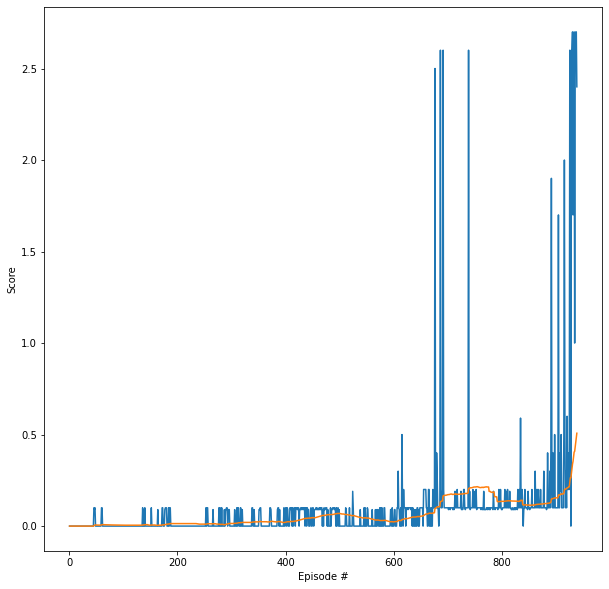

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores[0])+1), scores[0])
plt.plot(np.arange(1, len(scores[1])+1), scores[1])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [14]:
env.close()